In [1]:
from __future__ import print_function

import numpy as np
#import reflexxes
import random
import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
import datetime

import pickle

In [2]:
# load  clean data
# load noisy data
org_p = np.loadtxt('../Trajectory/data0503/original_position_list.csv', delimiter=' ')
#org_v = np.loadtxt('../Trajectory/data0503/original_velocity_list.csv', delimiter=' ')
nos_p_01 = np.loadtxt('../Trajectory/data0503/position_noise_0.1.csv', delimiter=' ')
nos_p_1 = np.loadtxt('../Trajectory/data0503/position_noise_1.csv', delimiter=' ')
nos_p_2 = np.loadtxt('../Trajectory/data0503/position_noise_2.csv', delimiter=' ')
nos_p_5 = np.loadtxt('../Trajectory/data0503/position_noise_5.csv', delimiter=' ')

traj_lens = np.loadtxt('../Trajectory/data0503/traj_lens.csv', delimiter=' ')
traj_lens = traj_lens.astype(int)

In [3]:
# reframe dataset as per traj_lens
traj_lens_cumsum = traj_lens.cumsum()
traj_lens_cumsum = np.delete(traj_lens_cumsum, len(traj_lens_cumsum) - 1)

org_p_spl = np.split(org_p, traj_lens_cumsum, axis=0)
#org_v_spl = np.split(org_v, traj_lens_cumsum, axis=0)
nos_p_01_spl = np.split(nos_p_01, traj_lens_cumsum, axis=0)
nos_p_1_spl = np.split(nos_p_1, traj_lens_cumsum, axis=0)
nos_p_2_spl = np.split(nos_p_2, traj_lens_cumsum, axis=0)
nos_p_5_spl = np.split(nos_p_5, traj_lens_cumsum, axis=0)

print(f'org_p.size: {len(org_p_spl)}')
print(f'nos_p_01_spl.size: {len(nos_p_01_spl)}')
print(f'nos_p_1_spl.size: {len(nos_p_1_spl)}')
print(f'nos_p_2_spl.size: {len(nos_p_2_spl)}')
print(f'nos_p_5_spl.size: {len(nos_p_5_spl)}')

org_p.size: 100
nos_p_01_spl.size: 100
nos_p_1_spl.size: 100
nos_p_2_spl.size: 100
nos_p_5_spl.size: 100


In [163]:
# plot data function
def on_key_press(event):
    if event.key == 'escape':
        plt.close()
        
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()

def plot_trajectory(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    #ax.scatter(xline, yline, zline, 'green')
    ax.plot3D(xline, yline, zline, 'green')

    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')
            
def plot_means(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.scatter(xline, yline, zline, 'green')
    #ax.plot3D(xline, yline, zline, 'green')

    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')

# def meanEuclideanDistanceError(real, model):
#     pred = model.predict(real)
#     error = 0
#     for i in range(len(pred)):
#         point = model.means_[pred[i]]
#         error += ((real[i][0] - point[0]) ** 2 + (real[i][1] - point[1]) ** 2 + (real[i][2] - point[2]) ** 2) ** 0.5
#     return error/len(real)

                     
def meanEuclideanDistanceError(noise, real, model):
    pred = model.predict(noise)
    error = 0
    for i in range(len(pred)):
        point = model.means_[pred[i]]
        error += ((real[i][0] - point[0]) ** 2 + (real[i][1] - point[1]) ** 2 + (real[i][2] - point[2]) ** 2) ** 0.5
    return error/len(real)

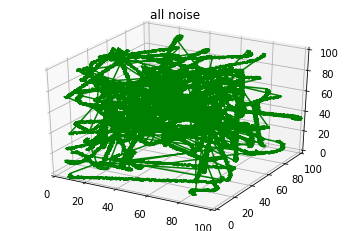

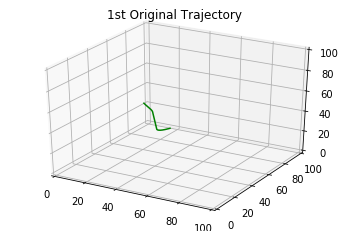

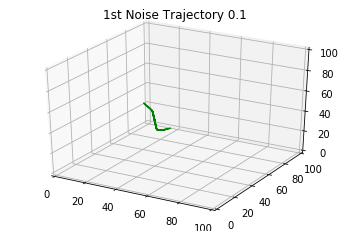

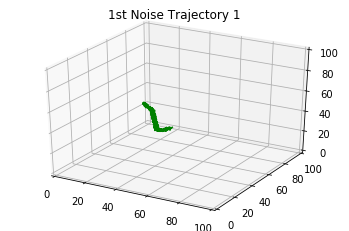

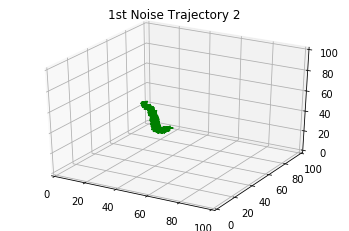

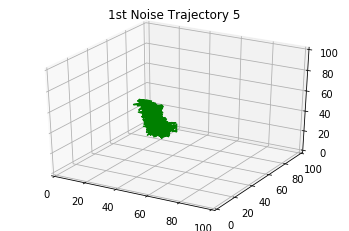

In [5]:
# plot 1st trajectory 
plot_trajectory(nos_p_1, 'all noise')
plot_trajectory(org_p_spl[0], '1st Original Trajectory')
plot_trajectory(nos_p_01_spl[0], '1st Noise Trajectory 0.1')
plot_trajectory(nos_p_1_spl[0], '1st Noise Trajectory 1')
plot_trajectory(nos_p_2_spl[0], '1st Noise Trajectory 2')
plot_trajectory(nos_p_5_spl[0], '1st Noise Trajectory 5')

In [6]:
# try label no. = 10

init_mean = []

# Hui Min CHANGE ME~~ : number of component in each diagonal
num = 5 

for i in range(num):
    for j in range(num):
        for k in range(num):
            init_mean.append([i * (100/num) + (50/num), j * (100/num) + (50/num), k * (100/num) + (50/num)])
#print(init_mean)   

a = datetime.datetime.now()
HMM_10 = hmm.GaussianHMM(n_components=num**3, covariance_type="spherical", init_params="sct", params="sct", n_iter=len(traj_lens), verbose=True)
HMM_10.means_ = init_mean

# fit data: change me (org_p) to nos_p_01
HMM_10.fit(nos_p_1, traj_lens)
b = datetime.datetime.now()
print(b-a)

         1     -929466.2596             +nan
         2     -811790.9602     +117675.2994
         3     -738358.4620      +73432.4982
         4     -663900.0034      +74458.4586
         5     -633584.6995      +30315.3039
         6     -629835.1840       +3749.5155
         7     -629341.1340        +494.0500
         8     -629217.4388        +123.6952
         9     -629119.8786         +97.5602
        10     -629061.7036         +58.1750
        11     -629025.4777         +36.2259
        12     -629005.5513         +19.9263
        13     -628969.6895         +35.8618
        14     -628958.5625         +11.1270
        15     -628957.9057          +0.6568
        16     -628957.7761          +0.1296
        17     -628957.5752          +0.2009
        18     -628957.0217          +0.5536
        19     -628956.1055          +0.9162
        20     -628955.7131          +0.3924
        21     -628955.5342          +0.1788
        22     -628954.0650          +1.4692
        23

1:12:16.473812


        28     -628949.8938          +0.0070


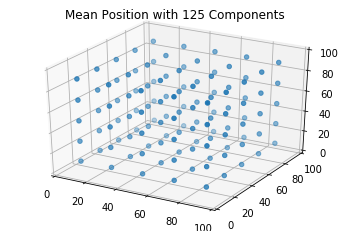

In [164]:
# plot means
plot_means(HMM_10.means_, 'Mean Position with 125 Components')
#print(HMM_10.means_)

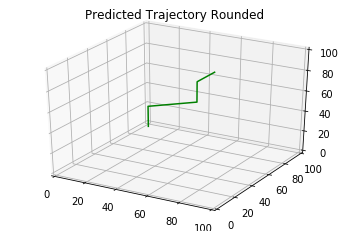

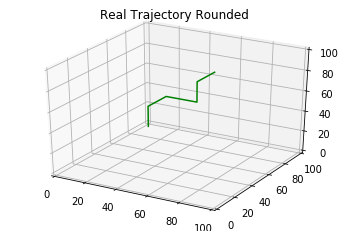

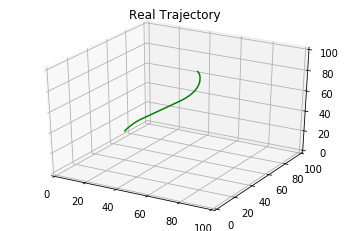

In [162]:
select_traj = 10

# load noise data for predict
replace = nos_p_5_spl[select_traj] 
# load clean data for comparison
real= org_p_spl[select_traj]    

pred = HMM_10.predict(replace)
orig_rd = np.ceil(real/20)*20-10
trej_rd = []
trej = []

for point in pred:
    #trej_rd.append(np.ceil(HMM_10.means_[point]/20)*20-10)
    trej_rd.append(HMM_10.means_[point])
plot_trajectory(trej_rd, 'Predicted Trajectory Rounded')
plot_trajectory(orig_rd, 'Real Trajectory Rounded')

for point in pred:
    trej.append(HMM_10.means_[point])
#plot_trajectory(trej, 'Trej')
plot_trajectory(real, 'Real Trajectory')



In [130]:
meanEuclideanDistanceError(replace, real, HMM_10)

9.891943110776436

In [131]:
#plot_trajectory(org_p, 'all data') # overall data

In [132]:
# Accuracy (%)
traj = real
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,init_mean)

#print("model accuracy is: ", np.mean(labels == HMM_10.predict(traj)))
print("model accuracy is: ", np.mean(labels == pred))

model accuracy is:  0.8942307692307693


In [11]:
# export model

with open("May03_5x5x5_noise1_no_velocity.pkl", "wb") as file: pickle.dump(HMM_10, file)
# use below to import   
#with open("filename.pkl", "rb") as file: HMM_10 = pickle.load(file)


# 1% outlier  c

In [133]:
outlier_01_c = np.loadtxt('../Trajectory/data/outlier_0.01-c/with_outlier_position.csv', delimiter=' ')
no_outlier_01_c = np.loadtxt('../Trajectory/data/outlier_0.01-c/ori_position.csv', delimiter=' ')
index_c = np.loadtxt('../Trajectory/data/outlier_0.01-c/outlier_indices.csv', delimiter=' ')
index_c = index_c.astype(int)

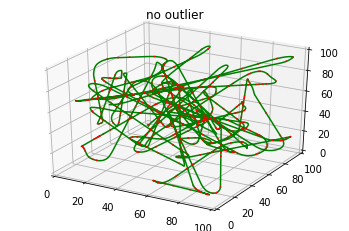

In [134]:
plot_trajectory(no_outlier_01_c, 'no outlier', index_c)

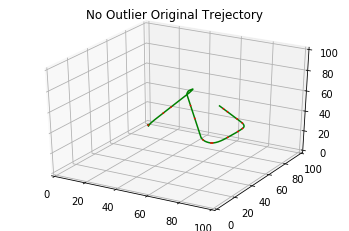

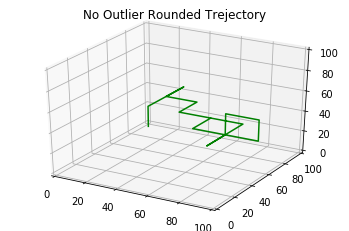

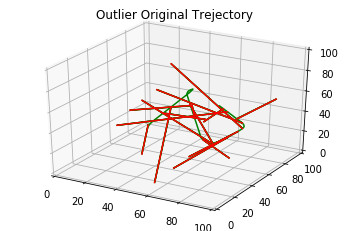

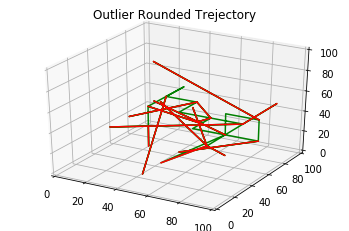

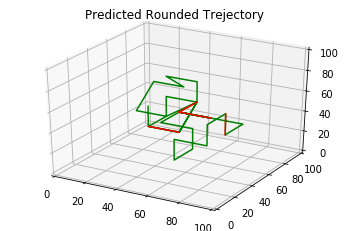

In [138]:
# make prediction on nosiy data with outliers 
pred = HMM_10.predict(outlier_01_c[0:2000])
orig_rd = np.ceil(no_outlier_01_c[0:2000]/20)*20-10
outlier_rd = np.ceil(outlier_01_c[0:2000]/20)*20-10

predict_rd = []

for point in pred:
    predict_rd.append(np.ceil(HMM_10.means_[point]/20)*20-10)
    
plot_trajectory(no_outlier_01_c[0:2000], 'No Outlier Original Trejectory',index_c)
plot_trajectory(orig_rd, 'No Outlier Rounded Trejectory',index_c)
plot_trajectory(outlier_01_c[0:2000], 'Outlier Original Trejectory',index_c)
plot_trajectory(outlier_rd, 'Outlier Rounded Trejectory',index_c)
plot_trajectory(predict_rd, 'Predicted Rounded Trejectory',index_c)

# for point in pred:
#     trej.append(HMM_10.means_[point])
#plot_trajectory(trej, 'Trej')
#plot_trajectory(real, 'Real Trej',index_c)

In [139]:
meanEuclideanDistanceError(outlier_01_c[0:2000], no_outlier_01_c[0:2000], HMM_10)

9.995133808463823

In [141]:
# Accuracy (%)
traj = no_outlier_01_c[0:2000]
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,init_mean)

#print("model accuracy is: ", np.mean(labels == HMM_10.predict(traj)))
print("model accuracy is: ", np.mean(labels == pred))

model accuracy is:  0.867


# Testing on turning original points  by 100-(x,y,z)

In [152]:
outlier_01_c_modified = [100,100,100] - outlier_01_c
no_outlier_01_c_modified = [100,100,100] - no_outlier_01_c

In [153]:
pred = HMM_10.predict(outlier_01_c_modified[0:2000])

# Accuracy (%)
traj = no_outlier_01_c_modified[0:2000]
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,init_mean)

#print("model accuracy is: ", np.mean(labels == HMM_10.predict(traj)))
print("model accuracy is: ", np.mean(labels == pred))

model accuracy is:  0.8355


In [154]:
meanEuclideanDistanceError(outlier_01_c_modified[0:2000], no_outlier_01_c_modified[0:2000], HMM_10)

10.137127139833277

In [159]:
real_m = [100,100,100] - real
replace_m = [100,100,100] - replace

In [160]:
pred = HMM_10.predict(replace_m)

# Accuracy (%)
traj = real_m
labels = np.zeros(len(traj))

def closest_node(node,nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2,axis=1)
    return np.argmin(dist_2)

for i,data in enumerate(traj):
    labels[i] = closest_node(data,init_mean)

#print("model accuracy is: ", np.mean(labels == HMM_10.predict(traj)))
print("model accuracy is: ", np.mean(labels == pred))

model accuracy is:  0.8692307692307693


In [161]:
meanEuclideanDistanceError(replace_m, real_m, HMM_10)

10.020352426294961